In [9]:
#!pip install -q catboost
#!pip install -q transformers

In [28]:
import pandas as pd
import numpy as np
import os
import csv
from zipfile import ZipFile
import torch
from scipy.stats import spearmanr
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from catboost import CatBoostRegressor
import xgboost as xgb
from transformers import AutoTokenizer, XLMRobertaModel
from typing import Dict, List, Tuple, Optional
import logging
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import spearmanr

In [29]:
class DataLoader:
    def __init__(self):
        self.setup_paths()
        self.setup_logging()

    def setup_logging(self):
        logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
        self.logger = logging.getLogger(__name__)

    def setup_paths(self):
        self.path_dev = 'dev/'
        self.path_train = 'train/'
        self.path_output = 'answer/'
        self.path_test = 'test/'

        for path in [self.path_dev, self.path_train, self.path_test, self.path_output]:
            if not os.path.exists(path):
                os.makedirs(path)

    def extract_zip_files(self):
        # Extract dev.zip
        if not os.listdir(self.path_dev):
            with ZipFile('dev.zip', 'r') as dev:
                dev.extractall(self.path_dev)

        # Extract train.zip
        if not os.listdir(self.path_train):
            with ZipFile('train.zip', 'r') as train:
                train.extractall(self.path_train)

        if not os.listdir(self.path_test):
            with ZipFile('test.zip', 'r') as test:
                test.extractall(self.path_test)

    def load_tsv_files(self):
        languages = os.listdir(self.path_train)
        self.logger.info(f"Found languages: {languages}")

        # Initialize file paths
        label_file_paths_train = []
        uses_file_paths_train = []
        label_file_paths_dev = []
        instance_file_paths_dev = []
        uses_file_paths_dev = []
        instance_file_paths_test = []
        uses_file_paths_test = []


        for lang in languages:
            label_file_paths_train.append(f"{self.path_train}{lang}/labels.tsv")
            uses_file_paths_train.append(f"{self.path_train}{lang}/uses.tsv")
            label_file_paths_dev.append(f"{self.path_dev}{lang}/labels.tsv")
            instance_file_paths_dev.append(f"{self.path_dev}{lang}/instances.tsv")
            uses_file_paths_dev.append(f"{self.path_dev}{lang}/uses.tsv")
            instance_file_paths_test.append(f"{self.path_test}{lang}/instances.tsv")
            uses_file_paths_test.append(f"{self.path_test}{lang}/uses.tsv")

        paths = {
            'train_labels_list': label_file_paths_train,
            'train_uses_list': uses_file_paths_train,
            'dev_labels_list': label_file_paths_dev,
            'dev_uses_list': uses_file_paths_dev,
            'dev_instances_list': instance_file_paths_dev,
            'test_uses_list': uses_file_paths_test,
            'test_instances_list': instance_file_paths_test
        }

        data_dict = {key: [] for key in paths.keys()}

        for save_path, path_list in paths.items():
            for path in path_list:
                with open(path, encoding='utf-8') as tsvfile:
                    language = path.split('/')[1]
                    reader = csv.DictReader(tsvfile, delimiter='\t',
                                         quoting=csv.QUOTE_MINIMAL, quotechar='"')
                    for row in reader:
                        row['language'] = language
                        data_dict[save_path].append(row)

        return data_dict

    def create_merged_dataframes(self, data_dict):
        def create_mappings(uses_list):
            id2context = {}
            id2idx = {}
            for row in uses_list:
                identifier = row['identifier']
                id2context[identifier] = row['context']
                id2idx[identifier] = row['indices_target_token']
            return id2context, id2idx

        # Create mappings
        train_id2context, train_id2idx = create_mappings(data_dict['train_uses_list'])
        dev_id2context, dev_id2idx = create_mappings(data_dict['dev_uses_list'])
        test_id2context, test_id2idx = create_mappings(data_dict['test_uses_list'])

        # Merge train data
        train_uses_merged = []
        for row in data_dict['train_labels_list']:
            identifier1_train = row['identifier1']
            identifier2_train = row['identifier2']

            data_row = {
                'context1': train_id2context.get(identifier1_train),
                'context2': train_id2context.get(identifier2_train),
                'index_target_token1': train_id2idx.get(identifier1_train),
                'index_target_token2': train_id2idx.get(identifier2_train),
                'identifier1': identifier1_train,
                'identifier2': identifier2_train,
                'lemma': row['lemma'],
                'mean_disagreement_cleaned': row['mean_disagreement_cleaned'],
                'judgments': row['judgments'],
                'language': row['language']
            }
            train_uses_merged.append(data_row)

        # Merge dev data
        dev_uses_merged = []
        for row in data_dict['dev_labels_list']:
            identifier1_dev = row['identifier1']
            identifier2_dev = row['identifier2']

            data_row = {
                'context1': dev_id2context.get(identifier1_dev),
                'context2': dev_id2context.get(identifier2_dev),
                'index_target_token1': dev_id2idx.get(identifier1_dev),
                'index_target_token2': dev_id2idx.get(identifier2_dev),
                'identifier1': identifier1_dev,
                'identifier2': identifier2_dev,
                'lemma': row['lemma'],
                'mean_disagreement_cleaned': row['mean_disagreement_cleaned'],
                'judgments': row['judgments'],
                'language': row['language']
            }
            dev_uses_merged.append(data_row)

        test_uses_merged = []
        for row in data_dict['test_instances_list']:
            identifier1_test = row['identifier1']
            identifier2_test = row['identifier2']

            data_row = {
                'context1': test_id2context.get(identifier1_test),
                'context2': test_id2context.get(identifier2_test),
                'index_target_token1': test_id2idx.get(identifier1_test),
                'index_target_token2': test_id2idx.get(identifier2_test),
                'identifier1': identifier1_test,
                'identifier2': identifier2_test,
                'lemma': row['lemma'],
                'language': row['language']
            }
            test_uses_merged.append(data_row)

        return pd.DataFrame(train_uses_merged), pd.DataFrame(dev_uses_merged), pd.DataFrame(test_uses_merged)

In [12]:
def plot_model_performance(y_true, y_pred, model_name="Model", save_path=None):

    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    spearman_corr, _ = spearmanr(y_true, y_pred)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    ax1.scatter(y_true, y_pred, alpha=0.5)

    min_val = min(min(y_true), min(y_pred))
    max_val = max(max(y_true), max(y_pred))
    ax1.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')

    ax1.set_xlabel('Actual Values')
    ax1.set_ylabel('Predicted Values')
    ax1.set_title(f'{model_name}: Predicted vs Actual')
    ax1.legend()


    ax1.grid(True, linestyle='--', alpha=0.7)

    metrics_text = (
        f'Metrics:\n'
        f'MSE: {mse:.4f}\n'
        f'RMSE: {rmse:.4f}\n'
        f'MAE: {mae:.4f}\n'
        f'R²: {r2:.4f}\n'
        f'Spearman Correlation: {spearman_corr:.4f}'
    )

    ax1.text(0.05, 0.95, metrics_text,
             transform=ax1.transAxes,
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    residuals = y_pred - y_true
    ax2.scatter(y_pred, residuals, alpha=0.5)
    ax2.axhline(y=0, color='r', linestyle='--', label='Zero Line')

    ax2.set_xlabel('Predicted Values')
    ax2.set_ylabel('Residuals')
    ax2.set_title('Residual Plot')
    ax2.legend()
    ax2.grid(True, linestyle='--', alpha=0.7)

    z = np.polyfit(y_pred, residuals, 1)
    p = np.poly1d(z)
    ax2.plot(y_pred, p(y_pred), "b--", alpha=0.8, label='Trend Line')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

    return {
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'spearman_correlation': spearman_corr
    }

In [30]:
data_loader = DataLoader()
data_loader.extract_zip_files()
data_dict = data_loader.load_tsv_files()
df_train_uses_merged, df_dev_uses_merged, df_test_uses_merged = data_loader.create_merged_dataframes(data_dict)

2024-11-16 07:40:20,413 - INFO - Found languages: ['chinese', 'spanish', 'german', 'norwegian', 'english', 'swedish', 'russian']


In [31]:
display(df_train_uses_merged.head())
display(df_dev_uses_merged.head())
display(df_test_uses_merged.head())

,context1,context2,index_target_token1,index_target_token2,identifier1,identifier2,lemma,mean_disagreement_cleaned,judgments,language
0,在大寨人自力更生建设山区革命精神的鼓舞下，他们下海围田，上山开荒，与自然奋战，向天公争粮,我一大早跑到了海边，沙滩上多了几条大木船，那是渔民下海夜里归来的吧,23:25,25:27,1966-14-12,1994-73-12,下海,0.0,"[3, 3]",chinese
1,”他瞅了瞅他现在穿的新皮大氅，又说：“过去我下海、在家，总是穿一件又腥又破的棉短袄；吃呢，一...,近年来，该报围绕“科技成果的评审和鉴定”、“上山与下海”、“科学研究如何选优和评价”等热点问...,22:24,25:27,1958-26-12,1994-53-12,下海,0.0,"[2, 2]",chinese
2,”他瞅了瞅他现在穿的新皮大氅，又说：“过去我下海、在家，总是穿一件又腥又破的棉短袄；吃呢，一...,我校乔刚同学在习作中给老师的信委婉地揭示出当前教师“下海”的现实，表达了学生对老师的依恋之情...,22:24,26:28,1958-26-12,1993-92-12,下海,1.0,"[2, 1]",chinese
3,驻守在沿海和海岛上的部队一面严密搜索海上敌情，保卫渔民生产，一面下海撒网捕捞鱼虾或在海边种海...,我们的老二，也就在这时候下定决心申请离职“下海”经商了,32:34,21:23,1961-42-12,1994-82-12,下海,0.0,"[2, 2]",chinese
4,驻守在沿海和海岛上的部队一面严密搜索海上敌情，保卫渔民生产，一面下海撒网捕捞鱼虾或在海边种海...,我一大早跑到了海边，沙滩上多了几条大木船，那是渔民下海夜里归来的吧,32:34,25:27,1961-42-12,1994-73-12,下海,0.0,"[4, 4]",chinese


,context1,context2,index_target_token1,index_target_token2,identifier1,identifier2,lemma,mean_disagreement_cleaned,judgments,language
0,为把假货拒之门外，济南国有商店规范经营活动，把打假防假工作作为企业生存、发展的根本，落实责任...,在努力帮助“农民长期得实惠”的同时，唐山市也积极探索让“干部长期受教育”的机制,50:52,37:39,1996-98-26,2002-79-26,机制,0.0,"[4, 4]",chinese
1,例如，疗效需要进一步巩固和提高，方法有待于进一步丰富和发展，机制理论的研究有待于进一步加强，...,目前一方面在深入研究传染性肝炎发病机制，另一方面已把这些总结出来的经验推广到全市,30:32,17:19,1960-37-26,1960-44-26,机制,2.0,"[4, 2]",chinese
2,其中《五十例阴虚患者症候分类分析及病理机制与治疗规律的探讨》、《对传染性肝炎的认识和探讨》等...,《条例》对公务员的录用、考核、升降、进出、监督、回避、轮换等都作出了明确的法令性的规定，有利...,19:21,61:63,1961-6-26,1993-65-26,机制,2.0,"[4, 2]",chinese
3,为把假货拒之门外，济南国有商店规范经营活动，把打假防假工作作为企业生存、发展的根本，落实责任...,由于各地党政领导重视创安工作，从人防、物防、技防上进一步强化了社区治安防范机制，预防和控制犯...,50:52,37:39,1996-98-26,1997-93-26,机制,0.0,"[4, 4]",chinese
4,为把假货拒之门外，济南国有商店规范经营活动，把打假防假工作作为企业生存、发展的根本，落实责任...,温州机制活，民间资金丰富，国内外市场渠道畅通，在目前市场疲软、资金短缺的情况下应该发挥优势，...,50:52,2:4,1996-98-26,1998-88-26,机制,0.0,"[1, 1]",chinese


,context1,context2,index_target_token1,index_target_token2,identifier1,identifier2,lemma,language
0,在运动中，几百万商业职工在商品的收购、包装、运输、装卸、搬运、保管、销售等各个环节上，费尽心...,在全国十二个中型氮肥厂中，生产能力提高最快，能源消耗最少，成本最低，利润最多，化肥包装质量最...,19:21,41:43,1964-16-30,1979-91-30,包装,chinese
1,在运动中，几百万商业职工在商品的收购、包装、运输、装卸、搬运、保管、销售等各个环节上，费尽心...,有些产品的质量、花色品种和包装装潢，与国际市场上同类产品相比，差距很大,19:21,13:15,1964-16-30,1978-5-30,包装,chinese
2,在运动中，几百万商业职工在商品的收购、包装、运输、装卸、搬运、保管、销售等各个环节上，费尽心...,如天津市调往外地的自行车，由于包装不好，每年报损二百四十多万元；北京市外调和市销的大瓶雪花膏...,19:21,15:17,1964-16-30,1978-40-30,包装,chinese
3,在运动中，几百万商业职工在商品的收购、包装、运输、装卸、搬运、保管、销售等各个环节上，费尽心...,要认真搞好产品的包装，货运部门的职工要增强责任感，减少装卸、运输过程中的损失,19:21,8:10,1964-16-30,1978-4-30,包装,chinese
4,在运动中，几百万商业职工在商品的收购、包装、运输、装卸、搬运、保管、销售等各个环节上，费尽心...,人们记得，最近几年来，苏联外长葛罗米柯年复一年在联大提出的“重要而紧急”的议题，都是那些换了...,19:21,47:49,1964-16-30,1977-8-30,包装,chinese


In [15]:
class EmbeddingGenerator:
    def __init__(self, model_name="FacebookAI/xlm-roberta-base"):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = XLMRobertaModel.from_pretrained(model_name)

    def truncation_indices(self, target_subword_indices, truncation_tokens_before_target=0.5):
        max_tokens = 512
        n_target_subtokens = target_subword_indices.count(True)
        tokens_before = int((max_tokens - n_target_subtokens) * truncation_tokens_before_target)
        tokens_after = max_tokens - tokens_before - n_target_subtokens

        lindex_target = target_subword_indices.index(True)
        rindex_target = lindex_target + n_target_subtokens
        lindex = max(lindex_target - tokens_before, 0)
        rindex = rindex_target + tokens_after

        return lindex, rindex

    def get_target_token_embedding(self, context, index):
        start_idx = int(str(index).strip().split(':')[0])
        end_idx = int(str(index).strip().split(':')[1])

        inputs = self.tokenizer(context, return_tensors="pt",
                              return_offsets_mapping=True, add_special_tokens=False)

        offset_mapping = inputs['offset_mapping'][0].tolist()
        input_ids = inputs['input_ids']
        tokens = self.tokenizer.convert_ids_to_tokens(input_ids[0])

        subwords_bool_mask = [
            (start <= start_idx < end) or (start < end_idx <= end)
            or (start_idx <= start and end <= end_idx)
            for start, end in offset_mapping
        ]

        if len(input_ids[0]) > 512:
            lindex, rindex = self.truncation_indices(subwords_bool_mask)
            tokens = tokens[lindex:rindex]
            input_ids = input_ids[:, lindex:rindex]
            subwords_bool_mask = subwords_bool_mask[lindex:rindex]
            inputs['input_ids'] = input_ids

        with torch.no_grad():
            outputs = self.model(inputs['input_ids'])

        target_embeddings = outputs.last_hidden_state[0][subwords_bool_mask]
        return target_embeddings.mean(dim=0).numpy()

    def generate_embeddings(self, df, file_name):
        id2embedding = {}

        for _, row in df.iterrows():
            identifier1 = row['identifier1']
            identifier2 = row['identifier2']

            if identifier1 not in id2embedding:
                embedding1 = self.get_target_token_embedding(row['context1'],
                                                          row['index_target_token1'])
                id2embedding[identifier1] = embedding1

            if identifier2 not in id2embedding:
                embedding2 = self.get_target_token_embedding(row['context2'],
                                                          row['index_target_token2'])
                id2embedding[identifier2] = embedding2

        np.savez(file_name, **id2embedding)
        return id2embedding

In [ ]:
#Generate embeddings
embedding_generator = EmbeddingGenerator()
train_embeddings = embedding_generator.generate_embeddings(df_train_uses_merged,
                                                         'subtask2_train_embeddings.npz')
dev_embeddings = embedding_generator.generate_embeddings(df_dev_uses_merged,
                                                       'subtask2_dev_embeddings.npz')

In [17]:
class ModelTrainer:
    def __init__(self):
        self.scaler = StandardScaler()
        self.trained_models = {}

    def create_features(self, embedding1, embedding2):
        concatenated = np.concatenate([embedding1, embedding2])
        difference = embedding1 - embedding2
        product = embedding1 * embedding2

        cos_sim = np.dot(embedding1, embedding2) / (
            np.linalg.norm(embedding1) * np.linalg.norm(embedding2))
        euclidean_dist = np.linalg.norm(embedding1 - embedding2)
        manhattan_dist = np.sum(np.abs(embedding1 - embedding2))#cumulative difference between each vector in the dim

        return np.concatenate([
            concatenated,
            difference,
            product,
            [cos_sim, euclidean_dist, manhattan_dist]
        ])

    def prepare_data(self, loaded_embeddings_file, df):
        loaded_embeddings = np.load(loaded_embeddings_file)
        features_list = []

        for _, row in df.iterrows():
            embedding1 = loaded_embeddings[row['identifier1']]
            embedding2 = loaded_embeddings[row['identifier2']]
            features = self.create_features(embedding1, embedding2)
            features_list.append(features)

        return np.array(features_list)

    def train_and_predict(self, X_train, y_train, X_dev):
        # Scale features
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_dev_scaled = self.scaler.transform(X_dev)

        models = {
            'cat': CatBoostRegressor(
                iterations=500,
                learning_rate=0.05,
                depth=6,
                random_seed=42,
                verbose=0
            ),
            'xgb': xgb.XGBRegressor(
                n_estimators=500,
                learning_rate=0.05,
                max_depth=6,
                subsample=0.8,
                colsample_bytree=0.8
            ),
            #'svr': SVR(kernel='rbf', C=1.0, epsilon=0.1)
        }

        # Perform 5-fold cross-validation
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        cv_scores = {name: [] for name in models.keys()}

        for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_scaled)):
            X_fold_train, X_fold_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
            y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]

            print(f"\nFold {fold + 1}/5")
            for name, model in models.items():
                print(f"Training {name}...")
                model.fit(X_fold_train, y_fold_train)
                y_pred = model.predict(X_fold_val)
                score = spearmanr(y_fold_val, y_pred)[0]
                cv_scores[name].append(score)
                print(f"{name} Spearman correlation: {score:.4f}")

        print("\nAverage CV Scores:")
        for name, scores in cv_scores.items():
            print(f"{name}: {np.mean(scores):.4f} ± {np.std(scores):.4f}")

        predictions = {}
        weights = {'cat': 0.4, 'xgb': 0.3}

        # Store trained models and scaler
        self.trained_models['scaler'] = self.scaler

        for name, model in models.items():
            print(f"\nTraining final {name} model...")
            model.fit(X_train_scaled, y_train)
            self.trained_models[name] = model
            predictions[name] = model.predict(X_dev_scaled)

        final_predictions = sum(weights[name] * pred for name, pred in predictions.items())
        return final_predictions, self.trained_models

    def predict_with_trained_models(self, X_test):
        """
        Make predictions using previously trained models
        """
        if not self.trained_models:
            raise ValueError("Models haven't been trained yet. Run train_and_predict first.")

        # Scale the test data using the stored scaler
        X_test_scaled = self.trained_models['scaler'].transform(X_test)

        # Make predictions with each model
        predictions = {}
        weights = {'cat': 0.4, 'xgb': 0.3}

        for name, model in self.trained_models.items():
            if name != 'scaler':
                predictions[name] = model.predict(X_test_scaled)

        final_predictions = sum(weights[name] * pred for name, pred in predictions.items())
        return final_predictions


In [18]:
model_trainer = ModelTrainer()
X_train = model_trainer.prepare_data('subtask2_train_embeddings.npz', df_train_uses_merged)
X_dev = model_trainer.prepare_data('subtask2_dev_embeddings.npz', df_dev_uses_merged)
y_train = df_train_uses_merged['mean_disagreement_cleaned'].astype(float).values


predictions, trained_models = model_trainer.train_and_predict(X_train, y_train, X_train)


Fold 1/5
Training cat...
cat Spearman correlation: 0.4820
Training xgb...
xgb Spearman correlation: 0.5295

Fold 2/5
Training cat...
cat Spearman correlation: 0.4738
Training xgb...
xgb Spearman correlation: 0.5319

Fold 3/5
Training cat...
cat Spearman correlation: 0.4817
Training xgb...
xgb Spearman correlation: 0.5359

Fold 4/5
Training cat...
cat Spearman correlation: 0.4900
Training xgb...
xgb Spearman correlation: 0.5370

Fold 5/5
Training cat...
cat Spearman correlation: 0.4967
Training xgb...
xgb Spearman correlation: 0.5534

Average CV Scores:
cat: 0.4848 ± 0.0078
xgb: 0.5376 ± 0.0084

Training final cat model...

Training final xgb model...


In [35]:
import pickle

with open("ensemble.pkl", 'wb') as f:
    pickle.dump(trained_models, f)


In [19]:
predictions

array([0.31899769, 0.32093387, 0.39468584, ..., 0.46776534, 0.6176893 ,
       0.48668809])

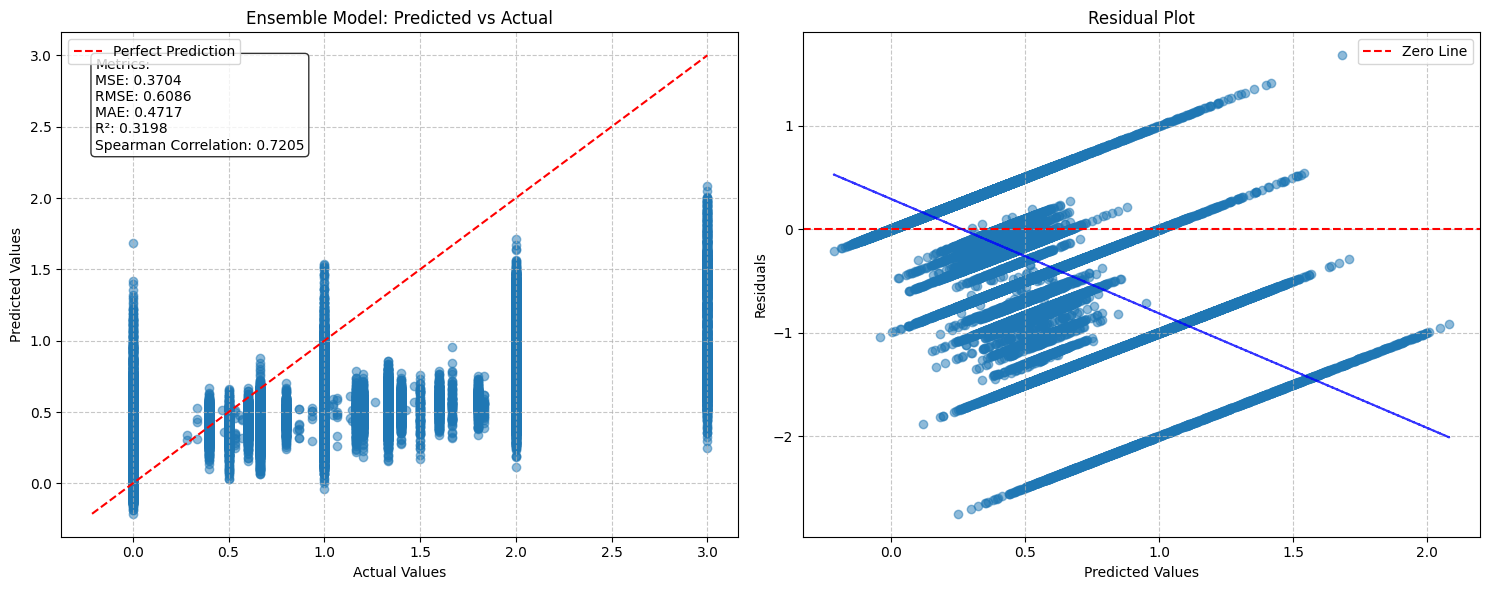


Detailed Model Performance Metrics:
MSE                      : 0.3704
RMSE                     : 0.6086
MAE                      : 0.4717
R2                       : 0.3198
SPEARMAN_CORRELATION     : 0.7205


In [20]:
metrics = plot_model_performance(y_train, predictions, model_name="Ensemble Model")

print("\nDetailed Model Performance Metrics:")
print("=" * 40)
for metric, value in metrics.items():
    print(f"{metric.upper():25}: {value:.4f}")

In [22]:
# predicting on the dev data per language

for language, group in df_dev_uses_merged.groupby('language'):
    dev_indices = group.index
    X_dev_ = X_dev[dev_indices]

    # predict using the fitted model
    y_pred = model_trainer.predict_with_trained_models(X_dev_)

    # add predictions to the dataframe
    df_dev_uses_merged.loc[dev_indices, 'prediction'] = y_pred

In [36]:
file_name = 'ensemble.pkl'
ensemble_model = pickle.load(open(file_name, 'rb'))

In [37]:
X_test = model_trainer.prepare_data('subtask2_test_embeddings.npz', df_test_uses_merged)

In [42]:
# predicting on the test data per language

for language, group in df_test_uses_merged.groupby('language'):
    test_indices = group.index
    X_test_ = X_test[test_indices]

    # predict using the fitted model
    y_pred_on_test = model_trainer.predict_with_trained_models(X_test_)

    # add predictions to the dataframe
    df_test_uses_merged.loc[test_indices, 'prediction'] = y_pred_on_test

In [ ]:
# create answer file in required format for codalab
#Evaluation on Dev
out_dir = 'answer/'
if not os.path.exists(out_dir):
        os.mkdir(out_dir)
answer_df = df_dev_uses_merged[['identifier1', 'identifier2', 'prediction', 'language']]
answer_df = answer_df.reset_index(drop= True)
for i in list(answer_df["language"].value_counts().index):
    df_temp = answer_df[answer_df["language"]==i]
    df_temp = df_temp.drop('language', axis=1)
    df_temp.to_csv('answer/' +i +'.tsv',index = False, sep='\t', quoting=csv.QUOTE_MINIMAL, quotechar='"')

with ZipFile('answer.zip', 'w') as zipf:
    for root, _, files in os.walk(out_dir):
        for file in files:
            zipf.write(os.path.join(root, file), arcname=file)

In [43]:
# create answer file in required format for codalab
#Evaluation on Test
out_dir = 'answer/'
if not os.path.exists(out_dir):
        os.mkdir(out_dir)
answer_df = df_test_uses_merged[['identifier1', 'identifier2', 'prediction', 'language']]
answer_df = answer_df.reset_index(drop= True)
for i in list(answer_df["language"].value_counts().index):
    df_temp = answer_df[answer_df["language"]==i]
    df_temp = df_temp.drop('language', axis=1)
    df_temp.to_csv('answer/' +i +'.tsv',index = False, sep='\t', quoting=csv.QUOTE_MINIMAL, quotechar='"')

with ZipFile('answer.zip', 'w') as zipf:
    for root, _, files in os.walk(out_dir):
        for file in files:
            zipf.write(os.path.join(root, file), arcname=file)

In [ ]:
answer_df.head()

In [32]:
def true_labels(df, ref):
  
    if not os.path.exists(ref):
        os.makedirs(ref)

    languages = df['language'].unique()

    for language in languages:
        lang_df = df[df['language'] == language][['identifier1', 'identifier2', 'mean_disagreement_cleaned']]

        lang_dir = os.path.join(ref, language)
        if not os.path.exists(lang_dir):
            os.makedirs(lang_dir)

        lang_file_path = os.path.join(lang_dir, 'labels.tsv')
        lang_df.to_csv(lang_file_path, sep='\t', index=False, quoting=csv.QUOTE_NONE)
        print(f"Saved truth labels for {language} at {lang_file_path}")

true_labels(df_dev_uses_merged, 'ref')


Saved truth labels for chinese at ref/chinese/labels.tsv
Saved truth labels for spanish at ref/spanish/labels.tsv
Saved truth labels for german at ref/german/labels.tsv
Saved truth labels for norwegian at ref/norwegian/labels.tsv
Saved truth labels for english at ref/english/labels.tsv
Saved truth labels for swedish at ref/swedish/labels.tsv
Saved truth labels for russian at ref/russian/labels.tsv
